In [69]:
import yfinance as yf
ticker = 'BTC-USD'
data = yf.download(ticker, start="2014-01-01", end="2024-06-27")
data

data.to_csv('./Sourcecode/bitcoin_df.csv')

[*********************100%%**********************]  1 of 1 completed


# chuẩn bị Data

In [47]:
import joblib
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller

data_train = pd.read_csv('./Sourcecode/bitcoin_df.csv')
# get data from 2018-01-01 to 2024-06-27
#data_train = data_train[data_train['Date'] >= '2018-01-01']
# get Date and Close columns from the data_train dataframe to df1 and set index to Date
df1 = data_train[['Date', 'Close']]
df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))
df1['log_return'] = df1['log_return'].fillna(0)

res = arch_model(df1['log_return'], vol='Garch', p=1, q=1,rescale=True).fit(update_freq=1)
#lưu giá trị dự đoán từ res vào df1['predicted_volatility']
df1['predicted_volatility'] = res.conditional_volatility


def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

test_stationarity(df1['log_return'])

C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_8704\3447738596.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))
C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_8704\3447738596.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_return'] = df1['log_return'].fillna(0)
C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_8704\3447738596.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Iteration:      1,   Func. Count:      6,   Neg. LLF: 94432.13521699907
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16377.993011602895
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2454.167678837417
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2218.2542419297606
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1405.6950197122596
Iteration:      6,   Func. Count:     46,   Neg. LLF: 1745.5422419585298
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1198.9286880566713
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1198.9216688498939
Iteration:      9,   Func. Count:     63,   Neg. LLF: 1198.9211498946534
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1198.9211277823538
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1198.9211277839377
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1198.9211277823538
            Iterations: 11
            Function evaluations: 72
            Gradient evalu

# Đưa ra biểu đồ PACF và ACF để chọn p q phù hợp

<Figure size 2000x2000 with 0 Axes>

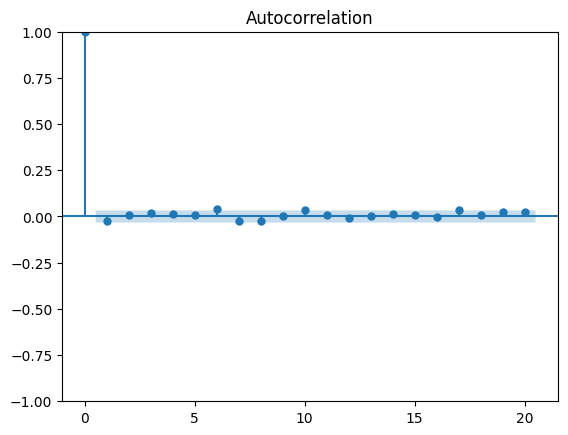

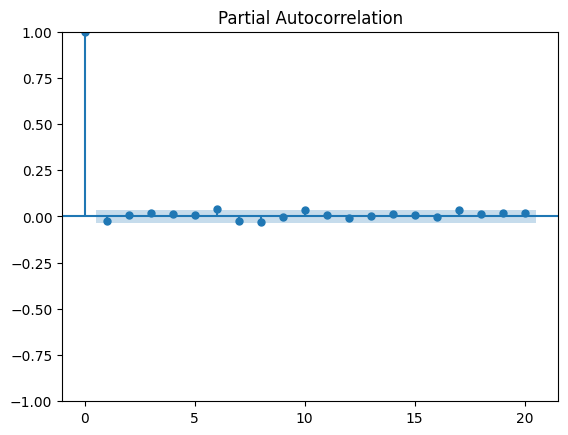

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plot_acf(df1['log_return'].dropna(), lags=20)
plot_pacf(df1['log_return'].dropna(), lags=20)
plt.show()

# Đưa ra mô hình ARMA để tạo Arma_Residuals phục vụ cho kiểm tra dữ liệu có tính Arch hay không(có thể hiệu là mức độ tương quan của dự liệu)

In [70]:
# arma test
par = 1
qar = 1
modelarma = ARIMA(df1['log_return'], order=(par, 0, qar))
modelarima_fit = modelarma.fit()
print(modelarima_fit.summary())
df1['Arma_resid'] = modelarima_fit.resid


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 3571
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6718.126
Date:                Sun, 30 Jun 2024   AIC                         -13428.251
Time:                        15:15:11   BIC                         -13403.529
Sample:                             0   HQIC                        -13419.437
                               - 3571                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.198      0.028       0.000       0.003
ar.L1         -0.0956      0.575     -0.166      0.868      -1.223       1.032
ma.L1          0.0726      0.575      0.126      0.8

### kiểm tra mô hình ARMA ở đây có thể xem là giả thuyết không tương quan bị phủ định khi p-value gần bằng 0

In [71]:
arch_test = het_arch(df1['Arma_resid'].dropna())
print('p-value of ARCH Test:', arch_test[1], ' p:', 1)

p-value of ARCH Test: 8.446605200024061e-19  p: 1


# xây dựng mô hình Garch và mô hình kết hợp giữa Garch và Arima

In [57]:
#Create Model

tmp = 1
for i in range(1, 10):
    for j in range(1, 10):
        model_garch_Arima = arch_model(df1['log_return'].dropna(), vol='Garch', p=i, q=j,rescale=True)
        arima_garch_result = model_garch_Arima.fit(disp="off")
        tmp2 = arima_garch_result.pvalues['mu']
        AIC = arima_garch_result.aic
        BIC = arima_garch_result.bic
        if tmp2 < tmp:
            tmp = tmp2
            print(f'p={i}, q={j}, p-value={tmp2}, AIC={AIC}, BIC={BIC}')
            p_tmp = i
            q_tmp = j
# print arch test result with the best p in hetarch model
model_garch = arch_model(df1['log_return'].dropna(), vol='Garch', p=p_tmp, q=q_tmp)
garch_result = model_garch.fit(disp="off")
df1['GARCH_Residuals'] = garch_result.resid
print(garch_result.summary())
tmp = 1
for i in range(1, 10):
    for j in range(1, 10):
        model_garch_Arima = arch_model(df1['Arma_resid'].dropna(), vol='Garch', p=i, q=j,rescale=True)
        arima_garch_result = model_garch_Arima.fit(disp="off")
        tmp2 = arima_garch_result.pvalues['mu']
        AIC = arima_garch_result.aic
        BIC = arima_garch_result.bic
        if tmp2 < tmp:
            tmp = tmp2
            print(f'p={i}, q={j}, p-value={tmp2}, AIC={AIC}, BIC={BIC}')
            pa_tmp = i
            qa_tmp = j

model_garch_Arima = arch_model(df1['Arma_resid'].dropna(), vol='Garch', p=pa_tmp, q=qa_tmp)
arima_garch_result = model_garch_Arima.fit(disp="off")
print(arima_garch_result.summary())
df1['Arima_GARCH_Residuals'] = arima_garch_result.resid

p=1, q=1, p-value=0.0016893833345686983, AIC=2405.8422555647076, BIC=2430.5646593550855
p=1, q=2, p-value=0.0014192808470736855, AIC=2404.3045003096404, BIC=2435.207505047613
p=1, q=3, p-value=0.001181790786874782, AIC=2370.5858620451318, BIC=2407.6694677306987
p=1, q=5, p-value=0.0010813768730286086, AIC=2374.5858620057174, BIC=2424.030669586473
p=6, q=5, p-value=0.0009501495034559231, AIC=2357.9254752827264, BIC=2438.2732876014543
p=8, q=7, p-value=0.000942501166061253, AIC=2359.5779404179793, BIC=2464.648156527085
p=9, q=7, p-value=0.0009374824742421008, AIC=2361.5779400029487, BIC=2472.828757059649


c:\Users\ThinhDo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7006.48
Distribution:                  Normal   AIC:                          -13977.0
Method:            Maximum Likelihood   BIC:                          -13865.7
                                        No. Observations:                 3571
Date:                Sun, Jun 30 2024   Df Residuals:                     3570
Time:                        15:00:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6119e-03  4.878e-04      3.304  9.523e-04 [6.

c:\Users\ThinhDo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# Bảng so sánh giá trị giữa 3 mô hình khi áp dụng lên dữ liệu

In [90]:
# in ra mean value của garch_result,modelarima_fit,arima_garch_result, đưa ra dạng bảng
df_mean = pd.DataFrame({
    'Model': ['GARCH', 'ARIMA', 'ARIMA_GARCH'],
    'p': [p_tmp, par, pa_tmp],
    'q': [q_tmp, qar, qa_tmp],
    'Mean': [garch_result.params['mu'], modelarima_fit.params['const'], arima_garch_result.params['mu']]
})
# in ra AIC, BIC value của garch_result,modelarima_fit,arima_garch_result, đưa ra dạng bảng
df_aic_bic = pd.DataFrame({
    'Model': ['GARCH', 'ARIMA', 'ARIMA_GARCH'],
    'AIC': [garch_result.aic, modelarima_fit.aic, arima_garch_result.aic],
    'BIC': [garch_result.bic, modelarima_fit.bic, arima_garch_result.bic]
})
print(df_mean)
print("--------------------------------------------------")
print(df_aic_bic)
# in ra p q value của garch_result,modelarima_fit,arima_garch_result, đưa ra dạng bảng, nếu không có p q thì để giá trị là Null
print("--------------------------------------------------")

# white noise test on Arima_GARCH_Residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
white_noise_test = acorr_ljungbox(df1['Arima_GARCH_Residuals'].dropna(), lags=1)
print(white_noise_test)


         Model  p  q      Mean
0        GARCH  9  7  0.001612
1        ARIMA  1  1  0.001367
2  ARIMA_GARCH  1  2  0.000335
--------------------------------------------------
         Model           AIC           BIC
0        GARCH -13976.954690 -13865.703873
1        ARIMA -13428.251175 -13403.528772
2  ARIMA_GARCH -13986.831062 -13962.108658
--------------------------------------------------
    lb_stat  lb_pvalue
1  0.006512   0.935684


In [79]:
model_garch_Arima = arch_model(df1['Arma_resid'].dropna(), vol='Garch', p=1, q=1)
arima_garch_result = model_garch_Arima.fit(disp="off")
df1['Arima_GARCH_Residuals'] = arima_garch_result.resid

c:\Users\ThinhDo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# Trực quan hoá dữ liệu và đưa ra dự đoán từ 'model_garch_Arima'

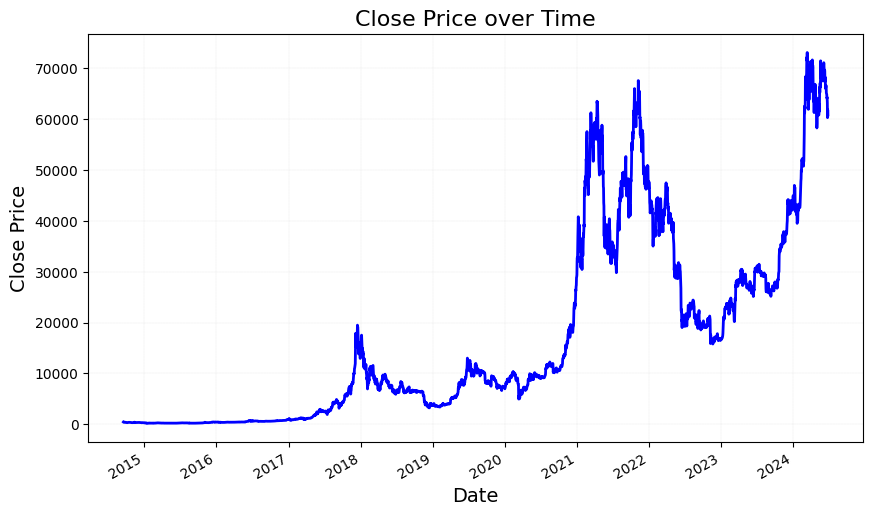

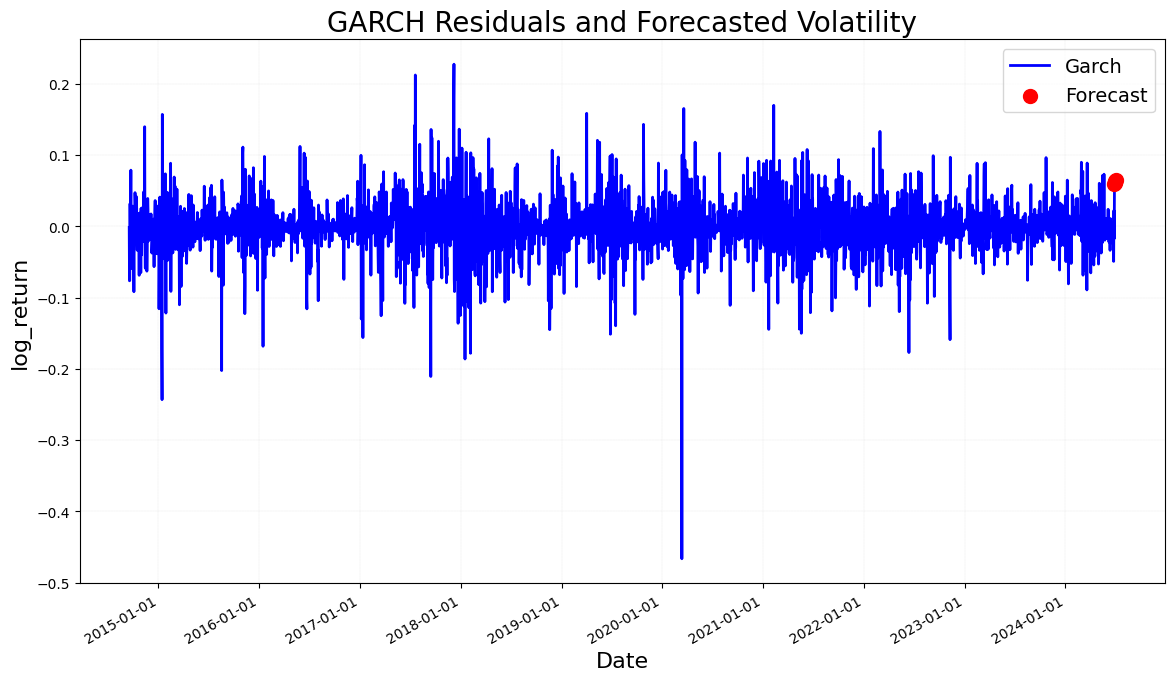

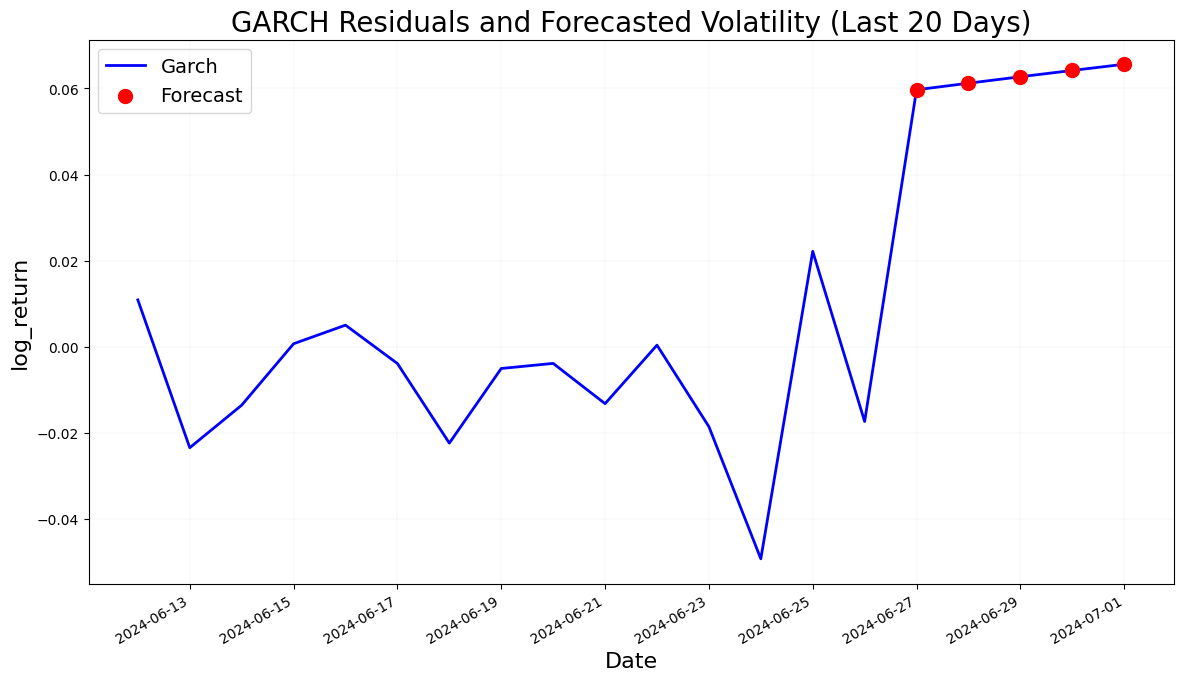

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Đảm bảo cột Date trong df1 là kiểu datetime
df1['Date'] = pd.to_datetime(df1['Date'])

# Biểu đồ 1: Close Price theo Date
plt.figure(figsize=(10, 6))
plt.plot(df1['Date'], df1['Close'], color='blue', linewidth=2)
plt.title('Close Price over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.gcf().autofmt_xdate()
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.show()

# Tạo forecastdf từ df1['Arima_GARCH_Residuals'] và forecasts.residual_variance
forecasts = arima_garch_result.forecast(horizon=5)
df_forecast = pd.DataFrame(forecasts.residual_variance)
new_df_forecast = df_forecast.melt(value_name='Forecast', var_name='header')[['Forecast']]

# Tạo DataFrame cho Arima_GARCH_Residuals và thêm cột phân loại
Arima_GARCH_Residuals_df = pd.DataFrame({
    'Date': df1['Date'],
    'Value': df1['Arima_GARCH_Residuals'],
    'Type': 0
})

# Tạo DataFrame cho Forecast và thêm cột phân loại
last_date = df1['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(new_df_forecast))

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Value': new_df_forecast['Forecast'] * 100,
    'Type': 1
})

# Kết hợp hai DataFrame lại với nhau
forecastdf = pd.concat([Arima_GARCH_Residuals_df, forecast_df], axis=0).reset_index(drop=True)

# Biểu đồ 2: GARCH-Arima Residuals và Forecast theo Date
plt.figure(figsize=(14, 8))
plt.plot(forecastdf['Date'], forecastdf['Value'], color='blue', linewidth=2, label='Garch')
plt.title('GARCH Residuals and Forecasted Volatility', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('log_return', fontsize=16)
plt.gcf().autofmt_xdate()
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.scatter(forecastdf[forecastdf['Type'] == 1]['Date'], forecastdf[forecastdf['Type'] == 1]['Value'], color='red', label='Forecast', s=100, zorder=5)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(fontsize=14)
plt.show()

# Biểu đồ 3: GARCH-Arima Residuals và Forecast theo Date (20 ngày gần nhất)
df3 = forecastdf[-20:]

plt.figure(figsize=(14, 8))
plt.plot(df3['Date'], df3['Value'], color='blue', linewidth=2, label='Garch')
plt.title('GARCH Residuals and Forecasted Volatility (Last 20 Days)', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('log_return', fontsize=16)
plt.gcf().autofmt_xdate()
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.scatter(df3[df3['Type'] == 1]['Date'], df3[df3['Type'] == 1]['Value'], color='red', label='Forecast', s=100, zorder=5)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(fontsize=14)
plt.show()
